![Py4Eng](img/logo.png)

# Generative Adversarial Networks
## Yoav Ram

In this session we will understand:
- how generative adversarial networks (GAN) are built and trained
- how to use generative adversarial networks to generate images that seem like they were drawn from the MNIST dataset

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from IPython.display import YouTubeVideo
import tensorflow as tf
try:
    import keras
except ModuleNotFoundError:
    from tensorflow import keras
print('Keras', keras.__version__)
print('GPU:', tf.test.is_gpu_available())
print(tf.test.gpu_device_name())

sns.set(
    style='ticks',
    context='talk',
    palette='Set1'
)

/Users/yoavram/miniconda3/envs/DataSciPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/yoavram/miniconda3/envs/DataSciPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/yoavram/miniconda3/envs/DataSciPy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/yoavram/miniconda3/en

Keras 2.3.1
GPU: False



Using TensorFlow backend.


# GAN

> Generative adversarial networks (GANs) are a class of artificial intelligence algorithms used in unsupervised machine learning, implemented by a system of two neural networks contesting with each other in a zero-sum game framework. -- [Wikipedia](https://en.wikipedia.org/wiki/Generative_adversarial_network)

A simple generative adversarial network is built by connecting two models: a _generative model_ and _discriminitive model_.

The generator recieves random input ("noise") and outputs "fake" data (e.g. image, text, sound) that is supposed to pass as a "real" data drawn from the sample dataset.

The disciminator recieves data and outputs a "fake" or "real" classification; that is, it discriminates between data generated by the generator and data from the sample dataset.

So the generator is trained to "fool" the discriminator, while the discriminator is trained to become "fool-proof".

See [original paper](https://arxiv.org/pdf/1406.2661.pdf) on arXiv.

![](https://skymind.ai/images/wiki/GANs.png)
Image credit: Thalles Silva

In the next we roughly follow an example given by [Erik Linder-Norén](https://github.com/eriklindernoren) on [GitHub](https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py) and a blog post on [KDnuggets](https://www.kdnuggets.com/2016/07/mnist-generative-adversarial-model-keras.html).

We will attempt to generate images that look like they are part of the MNIST dataset. But similar approaches have been successfully used with more sophisticated data.

# Disciminator

We will first build the discriminitive model, aka the discriminator.

We start with some definitions.

In [33]:
width = 28 
height = 28
channels = 1
npixels = width * height * channels
img_shape = (width, height, channels)
randoms_size = 100

optimizer = keras.optimizers.Adam(0.0002, 0.5)

We are going to use a straightforward FFN network (mainly because it works well on MNIST and can be trained efficiently without a GPU).
We'll use Keras because it's so easy to use.

Tow "dense" layers with 512 neurons each, and a [leaky ReLU](https://en.wikipedia.org/wiki/Rectifier_&#40;neural_networks&#41;#Leaky_ReLUs) activation function, followed by a logistic regression readout layer.

Because we will need to compose two networks, we create an input variable `img` and an output variable `validity` and pass them to a wrapping `Model` object.

In [14]:
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=img_shape),
    keras.layers.Dense(512),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(256),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(1, activation='sigmoid') # logistic output
], name='discriminator')

discriminator.compile(
    loss='binary_crossentropy', 
    optimizer=optimizer
)

In [15]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_______________________________________________

# Generator
Next up is the generator. We'll use four dense layers with increasing number of neurons, and the last one will create an array of the image, which we then reshape to get a 28x28x1 image.

We again use [leaky ReLU](https://en.wikipedia.org/wiki/Rectifier_&#40;neural_networks&#41;#Leaky_ReLUs) for activation, except for the last activation for which we use [hyperbolic tangent](https://en.wikipedia.org/wiki/Hyperbolic_function#Hyperbolic_tangent) to help saturate pixels into 0 or 1 states rather than a range of grays in between, and use [batch normalization](https://gab41.lab41.org/batch-normalization-what-the-hey-d480039a9e3b) to help accelerate training.

Finally, we create a new `Model` with input as an array of 100 numbers (which will be random numbers) and output as an image (28x28x1).


In [16]:
generator = keras.models.Sequential([
    keras.layers.Dense(256, input_shape=(randoms_size,)),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(512),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(1024),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.BatchNormalization(momentum=0.8),
    keras.layers.Dense(npixels, activation='tanh'),
    keras.layers.Reshape(img_shape)
], name='generator')

generator.compile(
    loss='binary_crossentropy', 
    optimizer=optimizer
)

In [17]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_12 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              52

# Combined model

For the combined model we will only train the generator, so let's tell that to Keras.

In [18]:
discriminator.trainable = False

Let's give the disciminator the `img` output variable produces by `generator` to get a `valid` output variable.

In [19]:
randoms = keras.Input(shape=(randoms_size,))
img = generator(randoms)
fake_real = discriminator(img)

The combined model  (stacked generator and discriminator) takes noise as input => generates images => determines validity.

In [20]:
combined = keras.models.Model(randoms, fake_real, name='combined')
combined.compile(
    loss='binary_crossentropy', 
    optimizer=optimizer
)

In [21]:
combined.summary()

Model: "combined"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
generator (Sequential)       (None, 28, 28, 1)         1493520   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


Note that we have three models now:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-0pky">input</th>
    <th class="tg-0pky">output</th>
    <th class="tg-0pky">loss function</th>
  </tr>
  <tr>
    <td class="tg-0pky">generator</td>
    <td class="tg-0pky">noise (100,)</td>
    <td class="tg-0pky">image (28,28,1)</td>
    <td class="tg-0pky">cross entropy</td>
  </tr>
  <tr>
    <td class="tg-0pky">discriminator</td>
    <td class="tg-0pky">image (28,28,1)</td>
    <td class="tg-0pky">valid (1,)</td>
    <td class="tg-0pky">cross entropy</td>
  </tr>
  <tr>
    <td class="tg-0pky">combined</td>
    <td class="tg-0pky">noise (100,)</td>
    <td class="tg-0pky">valid (1,)</td>
    <td class="tg-0pky">cross entropy</td>
  </tr>
</table>

we can train the discriminator on it's own by feeding it with real and fake images, but we cannot train the generator alone - it's loss function is cross entropy but it outputs images - because we don't have labels or targets for it. We can only train through the combined model: the $\widehat Y$ that are fed to the generator's loss function are the output of the discriminator, and the $Y$ are all ones (1s) because we want the generator to be able to get the discriminator to output ones ("reals").

In line with that, training the combined model only trains the generator (that's why we did `discriminator.trainable = False`), because when we train the discriminator we can't give it only "fake" images, we have to give it some "real" ones, too.

# Generating images

Function to generate and save images.

In [22]:
def save_imgs(idx):
    r, c = 5, 5
    randoms = np.random.normal(0, 1, (r * c, randoms_size))
    gen_imgs = generator.predict(randoms)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("../data/gan/mnist_{:05d}.png".format(idx))
    print("../data/gan/mnist_{:05d}.png".format(idx))
    plt.close()

# Data

Let's load the MNIST dataset through Keras' API.
We only need the train set as we don't actually use the labels.

In [23]:
(X_train, _), (_, _) = keras.datasets.mnist.load_data()

# Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

# Train

With very short training we already get basic results, but to get good ones we need to train for a long time. It took a couple of hours on my CPU-only laptop.

Training is divided to training the discriminator and then training the generator.

To train the discriminator we generate a batch of images and then give the discriminator the generated images and a batch of real images. The rest is standard for a classification model.

To train the generator we train the combined model (in which the discriminator training is off) by giving it noise and ones labels, because the target of the generator is to get the discriminator to produce ones ("real").

In contrast to standard training of classifiers, we expect (and even want) the accuracy of the discriminator to go up and down rather than trend up - every time the generator gets better, the discriminator can improve, and vice versa. 
Note that the only metric we have here is the loss and accuracy of the discriminator; we did not provide any metric for determining the quality of the generator beyond how it interacts with the discriminator.

We generate 9 random images every 100 epochs and save them as a multipanel figure.

In [11]:
batch_size=32
half_batch = int(batch_size / 2)
batches = 30000
save_interval = 200
print_interval = 100
nimages = X_train.shape[0]
history = {'dloss': np.empty(batches), 'gloss': np.empty(batches)}

for batch in range(batches):
    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    idx = np.random.randint(0, nimages, half_batch)
    real_imgs = X_train[idx]
    
    # Generate a half batch of new images
    randoms = np.random.normal(0, 1, (half_batch, randoms_size))
    fake_imgs = generator.predict(randoms)

    # Train the discriminator/
    d_loss_real = discriminator.train_on_batch(real_imgs, np.ones(half_batch))
    d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros(half_batch))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    history['dloss'][batch] = d_loss

    # ---------------------
    #  Train Generator
    # ---------------------

    # Generate randoms for a full batch of new images
    randoms = np.random.normal(0, 1, (batch_size, randoms_size))

    # Train the generator
    g_loss = combined.train_on_batch(randoms, np.ones(batch_size))
    history['gloss'][batch] = g_loss
    
    # Plot the progress
    if batch % print_interval == 0:
        print ("{:d} D loss: {:f}, G loss: {:f}".format(batch, d_loss, g_loss))

    # If at save interval => save generated image samples
    if batch % save_interval == 0:
        save_imgs(batch//save_interval)

/Users/yoavram/miniconda3/envs/Deep4Devs/lib/python3.6/site-packages/keras/engine/training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.797168, acc.: 53.12%] [G loss: 0.938396]
100 [D loss: 0.020080, acc.: 100.00%] [G loss: 4.398665]
200 [D loss: 0.327843, acc.: 78.12%] [G loss: 3.179523]
300 [D loss: 0.653026, acc.: 59.38%] [G loss: 0.767269]
400 [D loss: 0.667106, acc.: 53.12%] [G loss: 0.657380]
500 [D loss: 0.671012, acc.: 46.88%] [G loss: 0.712010]
600 [D loss: 0.682367, acc.: 53.12%] [G loss: 0.751250]
700 [D loss: 0.639636, acc.: 78.12%] [G loss: 0.718359]
800 [D loss: 0.651011, acc.: 65.62%] [G loss: 0.741840]
900 [D loss: 0.625552, acc.: 65.62%] [G loss: 0.761220]
1000 [D loss: 0.654933, acc.: 59.38%] [G loss: 0.794675]
1100 [D loss: 0.614258, acc.: 75.00%] [G loss: 0.813088]
1200 [D loss: 0.558516, acc.: 78.12%] [G loss: 0.836999]
1300 [D loss: 0.597502, acc.: 68.75%] [G loss: 0.914490]
1400 [D loss: 0.585008, acc.: 59.38%] [G loss: 0.915063]
1500 [D loss: 0.646844, acc.: 62.50%] [G loss: 1.010046]
1600 [D loss: 0.591847, acc.: 68.75%] [G loss: 0.884781]
1700 [D loss: 0.672455, acc.: 56.25%] [G l

In [21]:
generator.save('../data/gan_generator.h5')
discriminator.save('../data/gan_discriminator.h5')
combined.save('../data/gan_combined.h5')

In [25]:
with open('../data/gan_history.p', 'wb') as f:
    pickle.dump(history, f)

Call the following command to generate a time lapse movie from the saved multipanel figures.
```
avconv -f image2 -i 'mnist_%05d.png' -r 5 gan_evolution.mp4
```

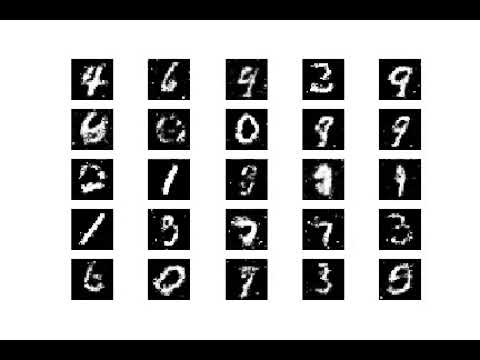

In [6]:
YouTubeVideo('N9qTNNx-4g4')

You can see that the generator very quickly becomes pretty good at generating nice digits, and then bounces around.

In [27]:
generator = keras.models.load_model('../data/gan_generator.h5')
discriminator = keras.models.load_model('../data/gan_discriminator.h5')
combined = keras.models.load_model('../data/gan_combined.h5')

/Users/yoavram/miniconda3/envs/DataSciPy/lib/python3.6/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [28]:
with open('../data/gan_history.p', 'rb') as f:
    history = pickle.load(f)

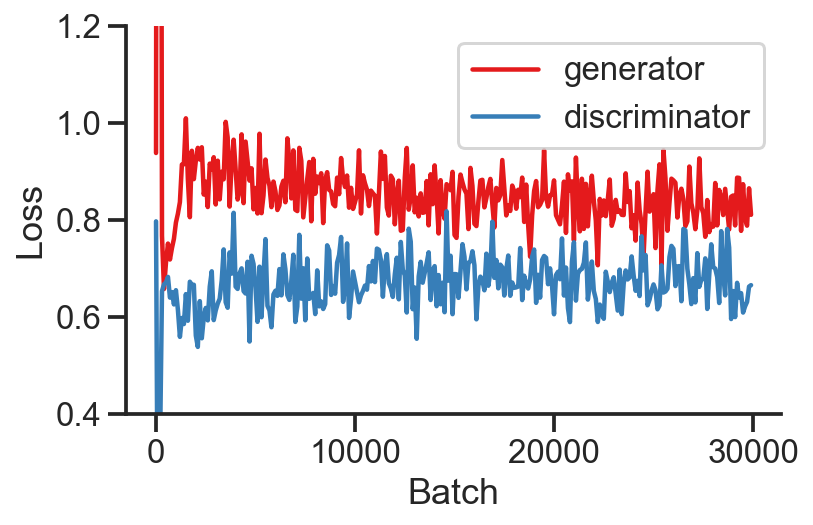

In [30]:
fig, ax = plt.subplots()

t = np.arange(0, history['dloss'].size, 100)
ax.plot(t, history['gloss'][::100], label='generator')
ax.plot(t, history['dloss'][::100], label='discriminator')
ax.set(ylim=(0.4, 1.2), xlabel='Batch', ylabel='Loss')
ax.legend(loc=1)

fig.tight_layout()
sns.despine()

You can see the loss function bouncing around, too.
One line is for the generator and the other for the discriminator, but they are not calculated on the same data even at the same epoch, so the correlation between them is not very strong.

Lastly, lets generate an image. Note that for "prediction" or generation we only need the generator and we can basically discard the discriminator and combined. If we'll need a discriminator we can always train one using the generator and the real data.

Real? 36.80%


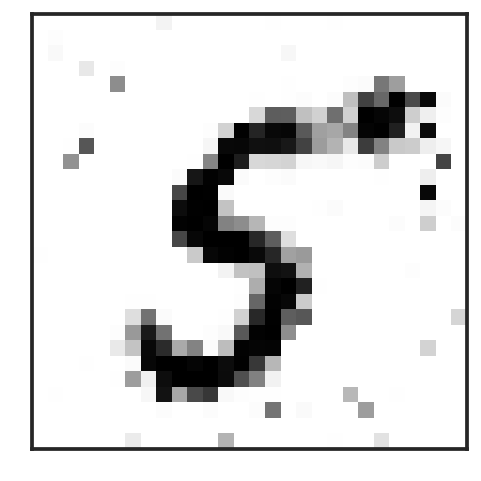

In [40]:
randoms = np.random.normal(0, 1, (1, randoms_size))
img = generator.predict(randoms).squeeze()
0.5 * img + 0.5
plt.imshow(img, cmap='gray_r')
plt.xticks([])
plt.yticks([])
fake_real = discriminator.predict(img.reshape(1, width, height, 1))[0, 0]
print("Real? {:.2%}".format(fake_real))

# Exercise

In the [exercise](../exercises/ACGAN.ipynb) you will extend the above adversarial network so that the generator recieves the specific digit to be generated, and the discriminator not only decides if an image is "fake" or "real", but also classifies the digit in the image. The framework I suggest you use is the [Auxiliary Classifier Generative Adversarial Network](https://arxiv.org/abs/1610.09585) where the "auxiliary classifier" is the additional classifier employed by the discriminator. This is instead of using two separate discriminators.

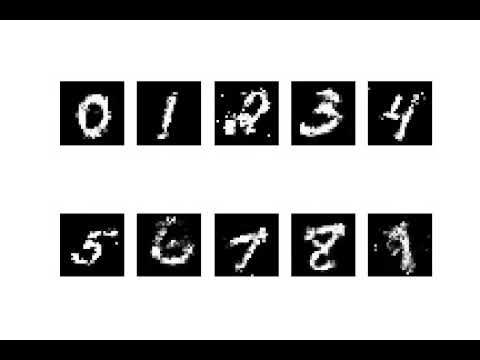

In [22]:
YouTubeVideo('-h-5YCfQUVU')

Of course you can devise your own model of how to pass a specific digit to the generator or use a model from the literature or [this long list of Keras implementations of GANs](https://github.com/eriklindernoren/Keras-GAN).

# Beyond MNIST

Similar but more sophisticated approaches have been successfully used with more sophisticated data. 

In [Image-to-Image Translation with Conditional Adversarial Nets](https://phillipi.github.io/pix2pix/) the input to the generator is not "noise" but rather one kind of data and the output is a transformation of the data.

![pix2pix](https://phillipi.github.io/pix2pix/images/edges2cats.jpg)

In [EnhanceNet: Single Image Super-Resolution Through Automated Texture Synthesis](http://webdav.tuebingen.mpg.de/pixel/enhancenet/) the input is a pixelated or low-resolution image and the output is a high-resolution image.

![](http://webdav.tuebingen.mpg.de/pixel/enhancenet/files/eagle-nn.jpg)![](http://webdav.tuebingen.mpg.de/pixel/enhancenet/files/eagle-pat.jpg)

# References

- [Goodfellow et al. 2014, arXiv:1406.2661](https://arxiv.org/abs/1406.2661), the original GAN paper
- [MNIST Generative Adversarial Model in Keras](https://www.kdnuggets.com/2016/07/mnist-generative-adversarial-model-keras.html) on KDnuggets
- Another [MNIST GAN implementation in Keras](https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0) by Rowel Atienza, with good graphics
- [Other types of GAN implemented in Keras](https://github.com/eriklindernoren/Keras-GAN) 

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

The notebook was written using [Python](http://python.org/) 3.7.

This work is licensed under a [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)